# Importando dependencias e dados

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Carregar dados
df = pd.read_csv("dataset.csv", parse_dates=['Event_Date', 'Weather_Date'])

# Ordenar os dados por Weather_Date
df = df.sort_values('Weather_Date').reset_index(drop=True)

# Trabalhando os dados

## Trabalhando as características
Iremos adicionar outras colunas que serão usadas para melhor treinamento do modelo, sendo elas:
 - **Precip_7d** -> Precipitação acumulada dos ultimos 7 dias
 - **Precip_3d** -> Precipitação acumulada dos ultimos 3 dias
 - **Precip_1d** -> Precipitação acumulada do ultimo 1 dia
 - **Ratio_1d_7d** -> Mede o peso da chuva do dia atual em relação ao acumulado dos últimos 7 dias.
    - **Cenário A**: choveu 50mm hoje e 0mm nos 6 dias anteriores -> Ratio_1d_7d ≈ 1
    - **Cenário B**: choveu 5mm hoje, mas já acumulava 100mm nos últimos dias -> Ratio_1d_7d ≈ 0.05
    - O cenário A tem mais chances de um alagamento então seu peso é maior
 - **Acceleration** -> Mede se a chuva de hoje está acima ou abaixo da média dos últimos 3 dias
    - Caso tenha um rápido aumento da intensidade da chuva é um sinal de alerta
 - **Impact_Score** -> métrica composta
     - Dá mais peso à chuva recente
     - Peso intermediário à chuva dos últimos 3 dias
     - Peso linear ao acumulado dos 7 dias

In [3]:
df['Precip_7d'] = df['Precipitation'].rolling(window=7, min_periods=1).sum()
df['Precip_3d'] = df['Precipitation'].rolling(window=3, min_periods=1).sum()
df['Precip_1d'] = df['Precipitation']

epsilon = 1e-6  # Para evitar divisão por zero
df['Ratio_1d_7d'] = df['Precip_1d'] / (df['Precip_7d'] + epsilon)
df['Acceleration'] = df['Precip_1d'] - (df['Precip_3d'] / 3)
df['Impact_Score'] = (df['Precip_1d'] ** 2) + (df['Precip_3d'] ** 1.5) + df['Precip_7d']

## Filtrando dados
Iremos filtrar os dados de alguns dias que não possuem enchentes para evitar classes muito desbalanceadas.
Como temos muitos mais dias sem enchentes do que dias com iremos nos concentrar apenas nas datas com o mesmo dia e mês que a data que ocorreu as enchentes.
Desta forma nosso modelo pode acabar muito bom em **prever dados sazonais** mas, no geral, enchentes estão relacionadas com chuvas sazonais então para um MVP não estamos considerando isso como um problema

In [4]:
filtered_df = df[
    (df['Flood'] == 1) |
    ((df['Weather_Date'].dt.month == df['Event_Date'].dt.month) &
    (df['Weather_Date'].dt.day == df['Event_Date'].dt.day))
].reset_index(drop=True)

# Treinamento e validação

In [15]:
# 🔸 Features e target
features = ['Precip_1d', 'Precip_3d', 'Precip_7d', 'Ratio_1d_7d', 'Acceleration', 'Impact_Score']
X = filtered_df[features]
y = filtered_df['Flood']

# 🔸 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# escalonamento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Função para treinar e testar o modelo para que seja possível a comparação e escolha do melhor para nossos dados

In [6]:
def avaliar_modelo(modelo, X_tr, y_tr, X_te, y_te, nome):
    modelo.fit(X_tr, y_tr)
    y_pred = modelo.predict(X_te)
    print(f"\n--- {nome} ---")
    print("Acurácia:", accuracy_score(y_te, y_pred))
    print(classification_report(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()

### KNN


--- KNN ---
Acurácia: 0.7058823529411765
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        25
           1       0.68      0.81      0.74        26

    accuracy                           0.71        51
   macro avg       0.71      0.70      0.70        51
weighted avg       0.71      0.71      0.70        51



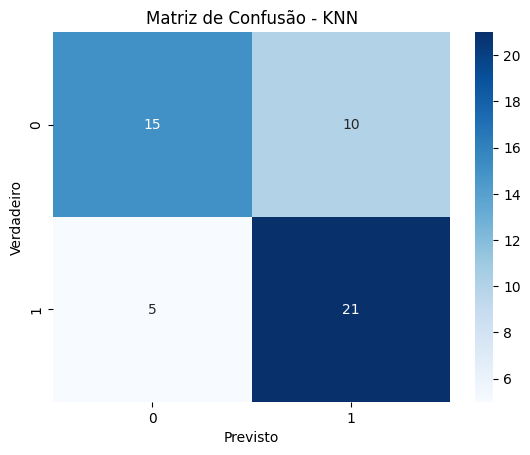

In [7]:
knn = KNeighborsClassifier(n_neighbors=5)
avaliar_modelo(knn, X_train_scaled, y_train, X_test_scaled, y_test, 'KNN')

### Regressão Logística


--- Regressão Logística ---
Acurácia: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        25
           1       0.65      0.77      0.70        26

    accuracy                           0.67        51
   macro avg       0.67      0.66      0.66        51
weighted avg       0.67      0.67      0.66        51



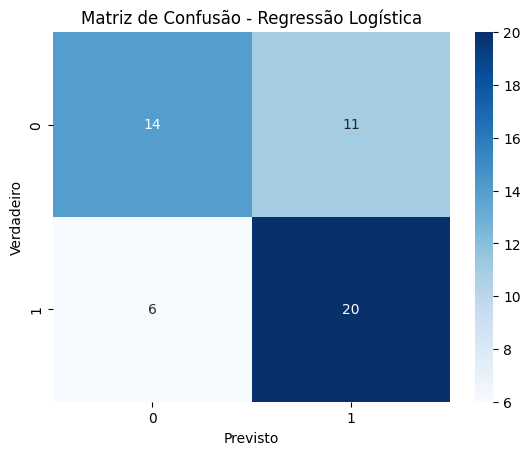

In [8]:
lr = LogisticRegression(max_iter=200)
avaliar_modelo(lr, X_train, y_train, X_test, y_test, 'Regressão Logística')

### Árvore de Decisão


--- Árvore de Decisão ---
Acurácia: 0.5098039215686274
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        25
           1       0.52      0.62      0.56        26

    accuracy                           0.51        51
   macro avg       0.51      0.51      0.50        51
weighted avg       0.51      0.51      0.50        51



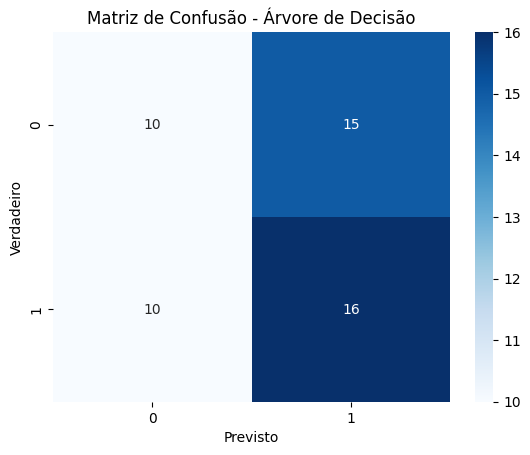

In [9]:
dt = DecisionTreeClassifier(random_state=42)
avaliar_modelo(dt, X_train, y_train, X_test, y_test, 'Árvore de Decisão')

### Floresta Aleatória


--- Floresta Aleatória ---
Acurácia: 0.6274509803921569
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        25
           1       0.64      0.62      0.63        26

    accuracy                           0.63        51
   macro avg       0.63      0.63      0.63        51
weighted avg       0.63      0.63      0.63        51



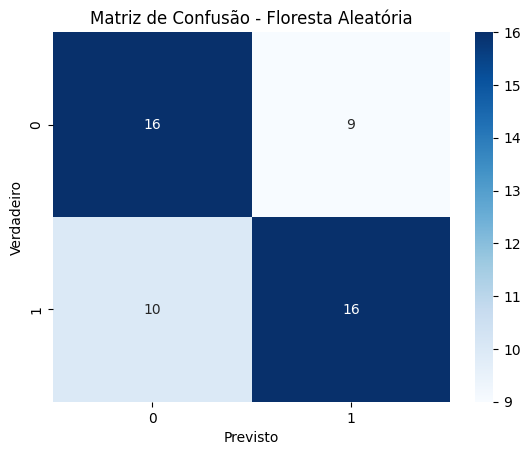

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
avaliar_modelo(rf, X_train, y_train, X_test, y_test, 'Floresta Aleatória')

### SVM


--- SVM ---
Acurácia: 0.6862745098039216
              precision    recall  f1-score   support

           0       0.74      0.56      0.64        25
           1       0.66      0.81      0.72        26

    accuracy                           0.69        51
   macro avg       0.70      0.68      0.68        51
weighted avg       0.70      0.69      0.68        51



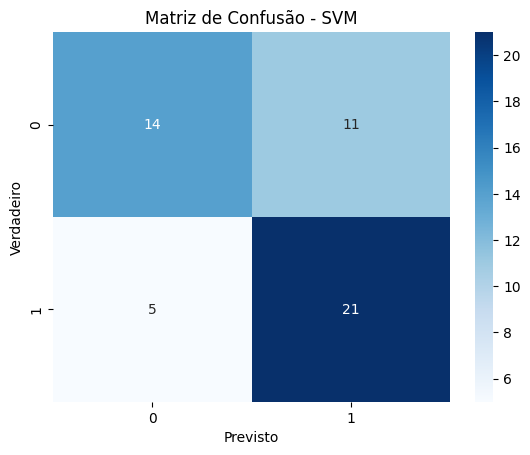

In [11]:
svm = SVC()
avaliar_modelo(svm, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM')

## Comparação

<Figure size 600x400 with 0 Axes>

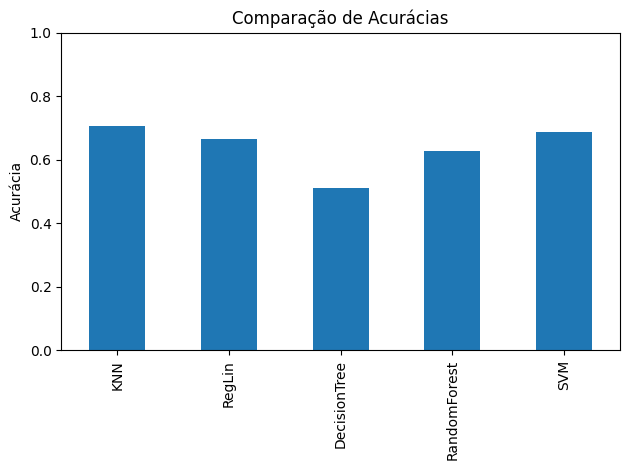

,Acurácia
KNN,0.705882
RegLin,0.666667
DecisionTree,0.509804
RandomForest,0.627451
SVM,0.686275


In [12]:
modelos = {'KNN': knn, 'RegLin': lr, 'DecisionTree': dt, 'RandomForest': rf, 'SVM': svm}
acuracias = {}
for nome, mod in modelos.items():
    X_te = X_test_scaled if nome in ['KNN','SVM'] else X_test
    acuracias[nome] = accuracy_score(y_test, mod.predict(X_te))

acc_df = pd.DataFrame.from_dict(acuracias, orient='index', columns=['Acurácia'])

plt.figure(figsize=(6,4))
acc_df.plot(kind='bar', legend=False)
plt.title('Comparação de Acurácias')
plt.ylabel('Acurácia')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

display(acc_df)

## Escolha do modelo
Análisando o desempenho de cada modelo seguiremos com o KNN para nossa versão definitiva. Sendo assim iremos então utilizar a lib joblib para exportar esse modelo e podermos utiliza-lo futuramente no Streamlit e na API

In [ ]:
import joblib

best_model = knn

joblib.dump(best_model, '../modelo/knn.joblib')
joblib.dump(scaler, '../modelo/scaler.joblib')

['scaler.joblib']